# 股票预测示例
## 1、获取股票数据


RNN与LSTM
RNN不具有重要性的筛选功能，短序列，时序一长，早期的东西就会忘记
LSTM加入遗忘门与记忆门（有用的东西加强记忆），长序列



### 1.1 根据时间获取一年的数据
##### 定义时间
start time：2019
end time : 2020

In [1]:
import datetime
from dateutil.relativedelta import relativedelta

dates = datetime.datetime.now() # 获取当前时间
date_nowday = dates.strftime('%Y-%m-%d') # 定义格式
date_preday = (dates-relativedelta(years=1)).strftime('%Y-%m-%d') # 获取一年以前的时间
print(date_nowday, date_preday)

2022-09-01 2021-09-01


### 1.2 同花顺接口

##### step 1 登陆: THS_iFinDLogin（）
##### step 2 获取数据：THS_HistoryQuotes（）
##### step 3 转换格式：THS_Trans2DataFrame（）
##### step 4 保存数据：to_csv(）

其他资源获取： http://tushare.org/

In [2]:
#from iFinDPy import *

#result_code = THS_iFinDLogin('username', 'password')
#a = THS_HistoryQuotes('000001.SZ', 'preClose,open,high,low,close,avgPrice,change,changeRatio,volume,amount,turnoverRatio,transactionAmount,totalShares,totalCapital,floatSharesOfAShares,floatSharesOfBShares,floatCapitalOfAShares,floatCapitalOfBShares,pe_ttm,pe,pb,ps,pcf', 'Interval:D,CPS:2,baseDate:1900-01-01,Currency:YSHB,fill:Omit', '2019-01-01', date_nowday, True)

# print(a)
#stock_df = THS_Trans2DataFrame(a)
#stock_df.to_csv('test.csv')
#print(stock_df.head(5))

## 2、读取股票数据

### 2.1 使用pandas读数据
##### 沪深300，2020年2月数据

In [2]:
import pandas as pd
df = pd.read_csv('stock.csv')
df

,code,date,open,close,high,low,turnoverRatio,volume,pb,pe
0,1,2020/2/3,13.772,13.772,14.482,13.772,1.164188,225919483,0.994337,9.628970
1,1,2020/2/4,13.832,14.382,14.442,13.802,0.879209,170617207,1.037693,10.048817
2,1,2020/2/5,14.372,14.412,14.672,14.102,0.768525,149138021,1.039825,10.069466
3,1,2020/2/6,14.592,14.552,14.652,14.292,0.611064,118581572,1.049775,10.165824
4,1,2020/2/7,14.382,14.402,14.472,14.192,0.476587,92485296,1.039114,10.062583
...,...,...,...,...,...,...,...,...,...,...
5995,603993,2020/2/24,4.487,4.367,4.497,4.217,2.618666,462607552,2.334465,51.293442
5996,603993,2020/2/25,4.287,4.557,4.577,4.247,3.128600,552691288,2.435043,53.503364
5997,603993,2020/2/26,4.457,4.337,4.497,4.307,2.016598,356247697,2.318584,50.944507
5998,603993,2020/2/27,4.357,4.337,4.427,4.277,1.201116,212186408,2.318584,50.944507


### 2.2  选用特征

#### 这里包括股票价格（开高低收）、市盈率和市净率（pb、pe）、成交量和换手率，其余指标可自行尝试

In [3]:
feature_list = ['code','date','open', 'close','high','low', 'pb', 'pe', 'turnoverRatio']

data = df[feature_list]
data.head(5) ## 看看开头的数据

,code,date,open,close,high,low,pb,pe,turnoverRatio
0,1,2020/2/3,13.772,13.772,14.482,13.772,0.994337,9.628970,1.164188
1,1,2020/2/4,13.832,14.382,14.442,13.802,1.037693,10.048817,0.879209
2,1,2020/2/5,14.372,14.412,14.672,14.102,1.039825,10.069466,0.768525
3,1,2020/2/6,14.592,14.552,14.652,14.292,1.049775,10.165824,0.611064
4,1,2020/2/7,14.382,14.402,14.472,14.192,1.039114,10.062583,0.476587


In [5]:
print(data.tail(5)) ## 看看结尾数据
print('\n'+'数据量为：'+str(len(data))) ## 看看数据量

        code       date   open  close   high    low        pb         pe  \
5995  603993  2020/2/24  4.487  4.367  4.497  4.217  2.334465  51.293442   
5996  603993  2020/2/25  4.287  4.557  4.577  4.247  2.435043  53.503364   
5997  603993  2020/2/26  4.457  4.337  4.497  4.307  2.318584  50.944507   
5998  603993  2020/2/27  4.357  4.337  4.427  4.277  2.318584  50.944507   
5999  603993  2020/2/28  4.187  4.027  4.267  3.997  2.154484  47.338846   

      turnoverRatio  
5995       2.618666  
5996       3.128600  
5997       2.016598  
5998       1.201116  
5999       1.658421  

数据量为：6000


In [6]:
stock_num = len(data['code'].unique())
day_num = len(data['date'].unique())
print('\n'+'股票数量：'+str(stock_num))
print('\n'+'天数：'+str(day_num))


股票数量：300

天数：20


### 2.3 准备 y

##### 涨标记为 1，跌标记 0； 采用后一天开盘价 - 今天开盘价

In [4]:
all_data = []
for index, group in data.groupby('code'):
    group['shift'] = group['open'].shift(-1) # open列上移一行赋给shift
    group['y'] = group['shift']-group['open']
    group['y'] = group['y'].apply(lambda x: 1 if x>0 else 0) # 涨赋为1，跌赋0，这里用apply应用一个lambda函数
    group.drop(['code','date','shift'],axis=1,inplace=True)
    all_data.extend(group.values[:-1]) # 删掉最后没有标签的那一行
print(len(all_data))

<ipython-input-4-622c10a61574>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['shift'] = group['open'].shift(-1) # open列上移一行赋给shift
<ipython-input-4-622c10a61574>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['y'] = group['shift']-group['open']
<ipython-input-4-622c10a61574>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

5700


In [8]:
all_data

[array([13.772     , 13.772     , 14.482     , 13.772     ,  0.99433697,
         9.62896952,  1.1641882 ,  1.        ]),
 array([13.832     , 14.382     , 14.442     , 13.802     ,  1.03769262,
        10.04881737,  0.87920943,  1.        ]),
 array([14.372     , 14.412     , 14.672     , 14.102     ,  1.03982487,
        10.06946562,  0.7685248 ,  1.        ]),
 array([14.592     , 14.552     , 14.652     , 14.292     ,  1.04977535,
        10.16582415,  0.61106402,  0.        ]),
 array([14.382     , 14.402     , 14.472     , 14.192     ,  1.03911412,
        10.06258287,  0.47658701,  0.        ]),
 array([14.292     , 14.282     , 14.312     , 14.082     ,  1.03058514,
         9.97998985,  0.69025678,  1.        ]),
 array([14.382     , 14.572     , 14.722     , 14.342     ,  1.05119684,
        10.17958965,  0.72530423,  1.        ]),
 array([14.572     , 14.552     , 14.602     , 14.382     ,  1.04977535,
        10.16582415,  0.5516422 ,  0.        ]),
 array([14.492     , 14.

### 2.4 准备数据
#### 源数据：[code1day1，code1day2，...]
#### 期望数据：[[code1所有天],[code2所有天]...]

In [7]:
import numpy as np
stock_y_origin = np.array(all_data)[:,-1]
train_stock_y = []
test_stock_y = []
for i in range(0, len(stock_y_origin), day_num-1):
    train_stock_y.append(stock_y_origin[i:i+int((day_num-1)*0.7)])
    test_stock_y.append(stock_y_origin[i+int((day_num-1)*0.7):i+day_num-1])
train_stock_y = np.array(train_stock_y)
test_stock_y = np.array(test_stock_y)
len(train_stock_y[0])

13

In [8]:
# 从读取的 pandas 数据中准备 x
stock_x_origin = np.array(all_data)[:,:-1]
train_stock_x = []
test_stock_x = []
for i in range(0, len(stock_x_origin), day_num-1):
    train_stock_x.append(stock_x_origin[i:i+int((day_num-1)*0.7)]) # 取前70%作为训练集
    test_stock_x.append(stock_x_origin[i+int((day_num-1)*0.7):i+day_num-1]) # 取后30%作为测试集
train_stock_x = np.array(train_stock_x)
test_stock_x = np.array(test_stock_x)
test_stock_x[1] # 输出一个看看

array([[28.49339   , 28.83339   , 28.85339   , 28.26339   ,  1.79395764,
         8.6789518 ,  0.82550926],
       [28.78339   , 28.23339   , 28.78339   , 27.98339   ,  1.75789819,
         8.50450051,  1.09025528],
       [28.08339   , 27.88339   , 28.13339   , 27.40339   ,  1.73686351,
         8.40273726,  0.97784761],
       [27.80339   , 28.31339   , 28.63339   , 27.78339   ,  1.76270612,
         8.52776068,  1.08384104],
       [27.83339   , 29.09339   , 29.94339   , 27.58339   ,  1.8095834 ,
         8.75454737,  1.70296217],
       [29.21339   , 28.65339   , 29.24339   , 28.36339   ,  1.78313981,
         8.62661642,  0.94981232]])

### 2.5 画图，探索数据

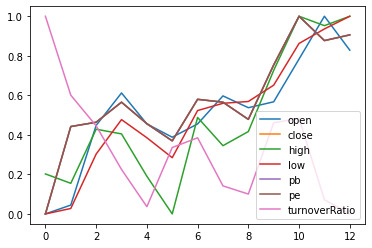

In [11]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 取某只股票的所有天
data_plot = train_stock_x[0]
# MinMax归一化
scaler = MinMaxScaler()
data_plot = scaler.fit_transform(data_plot)
# 去掉非结构化数据
feature_list = [x for x in feature_list if x not in ['code','date']]
data_plot = pd.DataFrame(data_plot, columns=feature_list)
data_plot.plot(kind="line")  ## pandas 可以直接画图，画出所有的列
# data['open'].plot(kind="line")
# plt.xlabel("Time")
# plt.ylabel("Price")
plt.show()
# print(data['pe'])

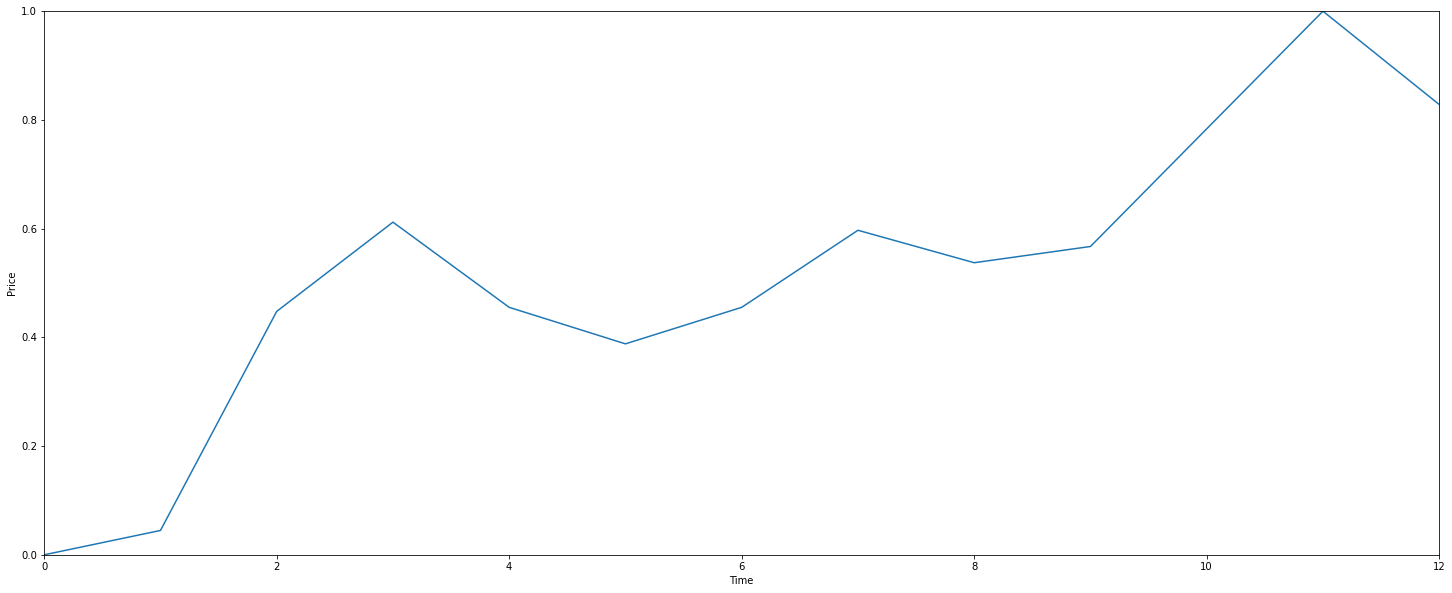

In [12]:
## 画单个列，设置刻度，以开盘价为例

data_plot['open'].plot(kind="line",xlim=(0,12),ylim=(0,1),figsize=(25,10))

## 设置依据  ---- xlim： 取12天的数据，ylim归一化到0-1，查看波动趋势

plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

### 2.6 面板数据的训练测试集


In [10]:
## 普通模型无法时序，所以转换为面板数据
train_x = np.reshape(train_stock_x, (-1,len(train_stock_x[0][0])))
test_x = np.reshape(test_stock_x, (-1,len(test_stock_x[0][0])))
train_y = np.reshape(train_stock_y, (-1))
test_y = np.reshape(test_stock_y, (-1))
print(len(train_x),len(train_y),len(test_x),len(test_y))

3900 3900 1800 1800


### 2.7 模型预测
#### 第一类模型：sklearn中分类模型
#### https://scikit-learn.org/   前去看一些参数，使用demo

In [11]:
from sklearn.svm import SVC

## 第一个使用svm

clf = SVC(C=2,kernel='rbf',gamma=10,decision_function_shape='ovr') ## 加载、定义模型
clf.fit(train_x, train_y) ## 喂训练数据
print("svm 测试集：",clf.score(test_x,test_y)) ## 预测，查看score：准确率

svm 测试集： 0.4988888888888889


In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn import tree

## 第二个使用决策树

## 并且用metrics评估里面的 report 查看结果报告

dtc = DecisionTreeClassifier()  ## 加载
dtc.fit(train_x, train_y) ## 给数据
y_predict = dtc.predict(test_x) ## 预测得到y的预测值

print(" DecisionTree 测试集：",dtc.score(test_x,test_y)) ## 同上，score得到准确率
print(classification_report(y_predict, test_y)) ## 更多的结果报告，机器学习评估依赖混淆矩阵

 DecisionTree 测试集： 0.595
              precision    recall  f1-score   support

         0.0       0.48      0.72      0.58       688
         1.0       0.75      0.52      0.61      1112

    accuracy                           0.59      1800
   macro avg       0.62      0.62      0.59      1800
weighted avg       0.65      0.59      0.60      1800



#### 第二类模型：pytorch自定义LSTM模型

In [13]:
import torch
from torch import nn
from torch.autograd import Variable
torch.cuda.is_available() # 显卡是否可用

False

LSTM:

    \begin{array}{ll}
        f^{t} = \sigma(W^{f}x^{t} + U^{f}h^{t-1}) \\
        i^{t} = \sigma(W^{i}x^{t} + U^{i}h^{t-1}) \\
        o^{t} = \sigma(W^{o}x^{t} + U^{o}h^{t-1}) \\
        \tilde{c^{t}} = tanh(W^{c}x^{t} + U^{c}h^{t-1}) \\
        c^{t} = f^{t} \odot c^{t-1} + i^{t} \odot \tilde{c^{t}} \\
        h_t = o^{t} \odot tanh(c^{t})
    \end{array}

In [14]:
class LSTM(nn.Module):

    def __init__(self, input_size, output_size, num_classes=2, classification=False): 
        # 输入维度（dataframe的特征维度）；隐藏层设置
        super(LSTM, self).__init__()# 参数编写
        self.hidden_size = output_size
        self.cell_size = output_size #与GRU不同
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        self.gate = nn.Linear(input_size + output_size, output_size)
        self.classification = classification
        if self.classification:
            self.output_dense = nn.Linear(output_size, num_classes)

    def forward(self, x, h_t, c_t): # 对应上面公式
        combined = torch.cat((x, h_t), 1)
        
        f = self.sigmoid(self.gate(combined))
        i = self.sigmoid(self.gate(combined))
        o = self.sigmoid(self.gate(combined))
        c = torch.add(torch.mul(c_t, f), torch.mul(self.tanh(self.gate(combined)), i))

        h = torch.mul(self.tanh(c), o)

        if self.classification:
            output = self.output_dense(h)
        else:
            output = h

        return output, h, c

    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size)) # 初始化

    def init_cell(self):
        return Variable(torch.zeros(1, self.cell_size)) # 初始化

GRU:

    \begin{array}{ll}
        z^{t} = \sigma(W^{z} \cdot [h^{t-1},x^{t}]) \\
        r^{t} = \sigma(W^{r} \cdot [h^{t-1},x^{t}]) \\
        \tilde{h^{t}} = tanh(W \cdot [r^{t} \odot h^{t-1},x^{t}]) \\
        h_t = (1-z^{t}) \odot h^{t-1} + z^{t} \odot \tilde{h^{t}}
    \end{array}

In [15]:
class GRU(nn.Module):
    def __init__(self, input_size, output_size, num_classes=2, classification=False):
        super(GRU, self).__init__()
        self.hidden_size = output_size
        self.cell_size = output_size
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        self.gate = nn.Linear(input_size + output_size, output_size)
        self.classification = classification
        if self.classification:
            self.output_dense = nn.Linear(output_size, num_classes)

    def forward(self, x, h_t):
        combined = torch.cat((x, h_t), 1)

        z = self.sigmoid(self.gate(combined))
        r = self.sigmoid(self.gate(combined))
        h_m = self.tanh(self.gate(torch.cat((x, torch.mul(r, h_t)), 1)))
        h = torch.add(torch.mul(z, h_m), torch.mul(1 - z, h_t)) # 与lstm不同，在公式里体现

        if self.classification:
            output = self.output_dense(h)
        else:
            output = h

        return output, h

    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

In [16]:
num_epochs = 50
GPU_id = "cuda:0" # 第0张显卡
device = torch.device(GPU_id if torch.cuda.is_available() else "cpu")
lr_init = 0.001
random_seed = 42
torch.manual_seed(random_seed)
input_size = len(train_stock_x[0][0])

# -----------------------Data & Model initialization----------------------- 数据与模型
train_x_tensor = torch.FloatTensor(train_stock_x).to(device)
day_num = train_x_tensor.shape[0]
LSTMmodel = LSTM(input_size=input_size, output_size=32, classification=True) # 分类问题
LSTMmodel = LSTMmodel.to(device)
GRUmodel = GRU(input_size=input_size, output_size=32, classification=True)
GRUmodel = GRUmodel.to(device)

# -----------------------Loss function、optimizer、learning rate-----------------------
# 交叉熵损失函数
criterion = torch.nn.CrossEntropyLoss()
# 梯度下降优化器Adam
LSTMmodelOptimizer = torch.optim.Adam(LSTMmodel.parameters(), lr=lr_init)
GRUmodelOptimizer = torch.optim.Adam(GRUmodel.parameters(), lr=lr_init)

In [17]:
# -----------------------Train-----------------------
LSTMmodel.train(mode=True)
print("Training...")
for epoch in range(num_epochs):
    total_loss = 0.0
    preds_train = []
    for stock in range(len(train_x_tensor)):
        # 梯度置零
        LSTMmodelOptimizer.zero_grad()
        # 初始化hidden和cell
        hidden = LSTMmodel.init_hidden().to(device)
        cell = LSTMmodel.init_cell().to(device)
        for x, label in zip(train_x_tensor[stock], train_stock_y[stock]):
            # 向量转张量(外层加个括号，因为输入的是个向量，但torch是个张量)
            x = x.unsqueeze(0)
            out, hidden, cell = LSTMmodel(x,hidden,cell)
        label = torch.LongTensor([label]).to(device)
        # 计算损失
        loss = criterion(out, label)
        # 计算梯度
        loss.backward()
        # 更新参数
        LSTMmodelOptimizer.step()
        total_loss += loss.item()
        
    print("Epoch: {}\tLoss: {}".format(epoch, total_loss / day_num), end="\n")

Training...


<ipython-input-17-5a30fad8c8de>:17: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.LongTensor([label]).to(device)


Epoch: 0	Loss: 0.6922781799236933
Epoch: 1	Loss: 0.687822521229585
Epoch: 2	Loss: 0.6742705018321673
Epoch: 3	Loss: 0.6748878293236097
Epoch: 4	Loss: 0.6717298995455107
Epoch: 5	Loss: 0.6697586066524188
Epoch: 6	Loss: 0.6674009775618712
Epoch: 7	Loss: 0.666502254207929
Epoch: 8	Loss: 0.6647336516280969
Epoch: 9	Loss: 0.6681589658061663
Epoch: 10	Loss: 0.6649914868672688
Epoch: 11	Loss: 0.6665428499877453
Epoch: 12	Loss: 0.6614833427468936
Epoch: 13	Loss: 0.6610263227671385
Epoch: 14	Loss: 0.6575948616862297
Epoch: 15	Loss: 0.6606728948404391
Epoch: 16	Loss: 0.6575564176837603
Epoch: 17	Loss: 0.6577810347701113
Epoch: 18	Loss: 0.6569640820970138
Epoch: 19	Loss: 0.660931955849131
Epoch: 20	Loss: 0.6541768553480506
Epoch: 21	Loss: 0.6532355183487137
Epoch: 22	Loss: 0.6519870059440533
Epoch: 23	Loss: 0.6505836764723063
Epoch: 24	Loss: 0.650031724429379
Epoch: 25	Loss: 0.6542891009586552
Epoch: 26	Loss: 0.6383935904658089
Epoch: 27	Loss: 0.6458330835122615
Epoch: 28	Loss: 0.6399298925946156

In [18]:
from sklearn.metrics import accuracy_score
# -----------------------Inference----------------------- # 测试集
test_x_tensor = torch.FloatTensor(test_stock_x).to(device)
day_num = train_x_tensor.shape[0]
labels_test = []
preds_test = []
LSTMmodel.eval()

# 测试时不需要更新参数,所以不需要算梯度,其他同训练流程
with torch.set_grad_enabled(False):
    for i in range(len(test_x_tensor)):
        hidden = LSTMmodel.init_hidden().to(device)
        cell = LSTMmodel.init_cell().to(device)
        for x, label in zip(test_x_tensor[i], test_stock_y[i]):
            x = x.unsqueeze(0)
            out, hidden, cell = LSTMmodel(x,hidden,cell)
        labels_test.append(label)
        label = torch.LongTensor([label]).to(device)
        # 得到概率更大的序号,
        _, out_binary = torch.max(out, 1)
        preds_test.append(out_binary.cpu().tolist()[0])

print("-------------------------------")
print("test accuracy_score: {}".format(accuracy_score(labels_test, preds_test)))

<ipython-input-18-da09dcc6b9a6>:18: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.LongTensor([label]).to(device)


-------------------------------
test accuracy_score: 0.63


In [19]:
# -----------------------Train-----------------------
GRUmodel.train(mode=True)
print("Training...")
for epoch in range(num_epochs):
    total_loss = 0.0
    preds_train = []
    for stock in range(len(train_x_tensor)):
        GRUmodelOptimizer.zero_grad()
        # GRU比LSTM少一个cell
        hidden = GRUmodel.init_hidden().to(device)
        for x, label in zip(train_x_tensor[stock], train_stock_y[stock]):
            x = x.unsqueeze(0)
            out, hidden = GRUmodel(x,hidden)
        label = torch.LongTensor([label]).to(device)
        loss = criterion(out, label)
        loss.backward()
        GRUmodelOptimizer.step()
        total_loss += loss.item()
        
    print("Epoch: {}\tLoss: {}".format(epoch, total_loss / day_num), end="\n")

Training...


<ipython-input-19-bf70698866f6>:14: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.LongTensor([label]).to(device)


Epoch: 0	Loss: 0.7063366155326366
Epoch: 1	Loss: 0.6877262405554454
Epoch: 2	Loss: 0.6815576076507568
Epoch: 3	Loss: 0.6770973992347717
Epoch: 4	Loss: 0.6733276802301407
Epoch: 5	Loss: 0.6717842362324397
Epoch: 6	Loss: 0.6685267242789269
Epoch: 7	Loss: 0.6636510714888573
Epoch: 8	Loss: 0.6653120837608973
Epoch: 9	Loss: 0.6598818715413411
Epoch: 10	Loss: 0.6579374559720357
Epoch: 11	Loss: 0.6519106464584669
Epoch: 12	Loss: 0.6545578663547834
Epoch: 13	Loss: 0.6482449855407079
Epoch: 14	Loss: 0.647776008695364
Epoch: 15	Loss: 0.6405704199771086
Epoch: 16	Loss: 0.6435562719404697
Epoch: 17	Loss: 0.635172634422779
Epoch: 18	Loss: 0.6366414438684781
Epoch: 19	Loss: 0.6250607255101204
Epoch: 20	Loss: 0.6268056695659955
Epoch: 21	Loss: 0.6256371740003427
Epoch: 22	Loss: 0.6181852069497108
Epoch: 23	Loss: 0.6140973525494338
Epoch: 24	Loss: 0.6159536611537139
Epoch: 25	Loss: 0.6061041961361965
Epoch: 26	Loss: 0.6083661241581043
Epoch: 27	Loss: 0.6017315623164177
Epoch: 28	Loss: 0.59699273395041

In [23]:
from sklearn.metrics import accuracy_score
# -----------------------Inference-----------------------
test_x_tensor = torch.FloatTensor(test_stock_x).to(device)
day_num = train_x_tensor.shape[0]
labels_test = []
preds_test = []
GRUmodel.eval()

with torch.set_grad_enabled(False):
    for i in range(len(test_x_tensor)):
        hidden = GRUmodel.init_hidden().to(device)
        for x, label in zip(test_x_tensor[i], test_stock_y[i]):
            x = x.unsqueeze(0)
            out, hidden = GRUmodel(x,hidden)
        labels_test.append(label)
        label = torch.LongTensor([label]).to(device)

        _, out_binary = torch.max(out, 1)
        preds_test.append(out_binary.cpu().tolist()[0])

print("-------------------------------")
print("test accuracy_score: {}".format(accuracy_score(labels_test, preds_test)))

<ipython-input-23-a4702c5b15e1>:16: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.LongTensor([label]).to(device)


-------------------------------
test accuracy_score: 0.7466666666666667
